In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor
pd.options.mode.chained_assignment = None  # default='warn'


# easy way of accessing A_6, A_7, ... A_N columns
def column_list(letter, start, end):
    return ["%s%d" % (letter, i) for i in range(start, end)]


def remove_outliers(column, target, first, second):
    non_outliers = target.between(target.quantile(first), target.quantile(second))
    count = 0

    for index in range(0, len(column)):
        if ~non_outliers[index]:
            count += 1
            column.drop(index, inplace=True)

    print("%i outliers were removed" % count)

# convert strings to int type even if it's a float
# replace by median or mean?
def convert_stat(x, new_value=0):
    if not isinstance(x, int):

        if not isinstance(x, float) and '.' not in x:
            return new_value if x == "TRANSFER" else int(x)
        else:
            return new_value if x == "TRANSFER" else int(float(x))

    else:
        return x


class SumTransformer(BaseEstimator):

    # set new_value to None if Pipeline contains SimpleImputer
    # this is for absences and tardies since somet students are
    # transfer students. The placeholder in the CSV is the string "TRANSFER"
    def __init__(self, new_value=0, bins=1, transformation="fixed"):
        self.new_value = new_value
        self.transformation = transformation
        self.bins = float(bins)

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        # change to for i in ["A", "T"] to include tardies if need be
        for i in ["A"]:

            # corrects the values in the data frame that will be used in the training models
            for j in column_list(i, 6, 9):

                # if no function is provided, the stats will be converted regularly
                # where it can be divided into fixed-width bins
                # though unnecessary, this is to make testing feature engineering much easier
                if self.transformation == "fixed":
                    df[j] = df[j].apply(lambda x: np.floor(convert_stat(x, self.new_value) / self.bins))
                elif self.transformation == "log":
                    df[j] = df[j].apply(lambda x: np.log((1 + convert_stat(x, new_value=self.new_value))))

                else:
                    raise Exception("Transformation argument was not correctly assigned.")

        return df

def run_test(data, target, pipeline, features_=["A6", "A7", "A8"]):

    scores_ = -1 * cross_val_score(pipeline,
                              data[features_],
                              data[target],
                              cv=5,
                              scoring='neg_mean_absolute_error')

    return scores_

print("pass")

pass


After setting up the functions needed for pre-processing, I set up the data. There are necessary pre-processing
*before* the actual pre-processing. Because some numerical columns contain string types, it is necessary
to convert them. Also, outliers are determined before the split (or pipeline), and removed.

In [199]:
student_data = pd.read_csv("../data/High School East Student Data - Sheet1.csv")
features = ["A6", "A7", "A8"]
student_data["AbsencesSum_HS"] = 0

# Pipeline doesn't allow transformations on the target label
# so I have to do transformations outside of Pipeline in order
# to sum all absences in High School for each student.
for j in column_list("A", 9, 13):
    student_data[j] = student_data[j].apply(convert_stat)

student_data["AbsencesSum_HS"] = student_data[column_list('A', 9, 13)].sum(axis=1)

# because we've created the total absences in high school column
# we are now able to eliminate outliers in the dataset.
remove_outliers(student_data, student_data["AbsencesSum_HS"], 0, 0.95)

pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('categories', OneHotEncoder(), ["Gender", "IEP/Specialized"])])

model_pipeline = Pipeline(steps=[('number_fix', SumTransformer()),
                                 ('model', DecisionTreeRegressor(random_state=1))
                                 ])

#######################################
# Sorta like unit testing but in jupyter
test = run_test(student_data, "AbsencesSum_HS", model_pipeline)
prior_run = np.array([23.43076923, 16.23076923, 15.76923077, 17.93846154, 19.58333333])

if not np.allclose(test, prior_run, atol=0.001):
    raise Exception("Modification to pre-processing led to unintended results.")
#######################################

print("pass")

4 outliers were removed
pass


# 2. Feature Engineering Tests
I create a new copy of the student_data because the student_data will serve as a model for the many feature engineering
tests in this notebook.
## 2.1 Binning the Data
https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b
### 2.1.1 Fixed-Width

Scores:  [17.33731809 17.19736842 14.80473373 12.24116424 12.71544715]
Score mean:  14.859206326363434
Score variances:  4.612170978352201


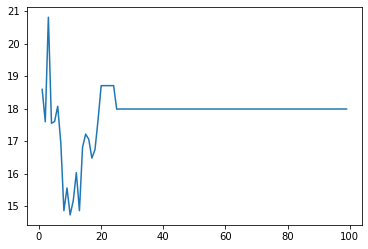

<Figure size 432x288 with 0 Axes>

In [225]:
import copy as cp

model_pipeline = Pipeline(steps=[('number_fix', SumTransformer(transformation="fixed", bins=13)),
                             #    ('preprocess', pre_process),
                                 ('model', DecisionTreeRegressor(random_state=1))
                                 ])

data_copy = cp.deepcopy(student_data)

#comparing fixed width binning and dynamic width binning
data_copy["HS_AB_FIXED"] = np.array(np.floor(np.array(data_copy["AbsencesSum_HS"])))

scores_fixed = np.array(run_test(data_copy, "HS_AB_FIXED", model_pipeline, features_=features))

print("Scores: ", scores_fixed)
print("Score mean: ", np.mean(scores_fixed))
print("Score variances: ", np.var(scores_fixed))

scores = []

#set to True if you want to graph the binning results
if True:
    for i in range(1,100):
        pipe = Pipeline(steps=[('number_fix', SumTransformer(bins=i)),
                                #     ('preprocess', pre_process),
                                     ('model', DecisionTreeRegressor(random_state=1))
                                     ])

        scores.append(np.mean(np.array(run_test(data_copy, "HS_AB_FIXED", pipe, features_=features))))

    fig, ax = plt.subplots()
    ax.plot(range(1,100), scores)

    fig.savefig("test.png")
    plt.show()
    plt.clf()

### 2.1.2 Log Binning

In [214]:
data_copy_log = cp.deepcopy(student_data)

log_binning_pipeline_test = Pipeline(steps=[('number_fix', SumTransformer(transformation="log")),
                            #     ('preprocess', pre_process),
                                 ('model', DecisionTreeRegressor(random_state=1))
                                 ])


scores_log = np.array(run_test(data_copy_log, "AbsencesSum_HS", log_binning_pipeline_test, features_=features))

print("Scores: ", scores_log)
print("Score mean: ", np.mean(scores_log))
print("Score variances: ", np.var(scores_log))

Scores:  [21.96923077 16.69230769 14.69230769 16.95384615 20.16666667]
Score mean:  18.094871794871796
Score variances:  6.829911900065748


The first model I will test is the Decision Tree Regressor.

In [ ]:
tree = DecisionTreeRegressor(random_state=1)

"""
model_pipeline.fit(student_data[features], student_data["AbsencesSum_HS"])

importances = model_pipeline.named_steps['Decision Tree'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(7):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

scores = -1 * cross_val_score(run_test(tree, "Decision Tree"),
                              student_data[features],
                              student_data["AbsencesSum_HS"],
                              cv=5,
                              scoring='neg_mean_absolute_error')

#print(np.mean(scores))
"""

Testing the optimal number of features.

In [ ]:
model_pipeline = Pipeline(steps=[('number_fix', SumTransformer()),
                                 ('pre_process', pre_process),
                                 ('Decision Tree', tree)
                                 ])


print("hell")
%matplotlib inline

#RVEFC for determining optimal number of features??